## Purchase Propensity Model: Debit Card (most sold product, and preferred by new customers)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 100
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
from pandas import json_normalize
from scipy import stats
from datetime import datetime
from sklearn import model_selection
import xgboost as xgb
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, balanced_accuracy_score



from sklearn.tree import export_graphviz
import graphviz

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
df = pd.read_csv("./df_todo_modelo_SHIFT.csv")


C:\Users\mirei\AppData\Local\Temp\ipykernel_16792\2017636902.py:1: DtypeWarning: Columns (24,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./df_todo_modelo_SHIFT.csv")


In [4]:
df.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
pk_cid,1375586,1050611,1050612,1050613,1050614,1050615,1050616,1050617,1050619,1050620,1050621,1050622,1050623,1050624,1050625,1050626,1050610,1050627,1050609,1050605
pk_partition,2018-01-01,2018-01-01,2018-01-01,2018-01-01,2018-01-01,2018-01-01,2018-01-01,2018-01-01,2018-01-01,2018-01-01,2018-01-01,2018-01-01,2018-01-01,2018-01-01,2018-01-01,2018-01-01,2018-01-01,2018-01-01,2018-01-01,2018-01-01
CUST_entry_date,2018-01-01,2015-08-01,2015-08-01,2015-08-01,2015-08-01,2015-08-01,2015-08-01,2015-08-01,2015-08-01,2015-08-01,2015-08-01,2015-08-01,2015-08-01,2015-08-01,2015-08-01,2015-08-01,2015-08-01,2015-08-01,2015-08-01,2015-08-01
CUST_entry_channel,KHL,KHE,KHE,KHD,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KFA,KHE
CUST_active_customer,1,0,0,0,1,0,0,1,0,0,0,0,1,1,1,1,1,0,1,0
CUST_segment,02 - PARTICULARES,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,02 - PARTICULARES,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO,03 - UNIVERSITARIO
PROD_short_term_deposit_lag1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PROD_loans_lag1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PROD_mortgage_lag1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PROD_funds_lag1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Definition and Mean of TARGET and PROD:

In [5]:
TARGET = "HAY_VENTA_em_acount"
PROD = "PROD_em_acount_lag1"

In [6]:
# Target mean = 0.02
df[TARGET].mean()

0.01957296619490748

### Product Columns (PROD)
We keep all columns except PROD_em_acount_lag1 (because that is our target, what we are trying to predict)

In [7]:
columnas_PROD = df.columns[df.columns.str.startswith(('PROD_'))].tolist()
columnas_PROD.remove(PROD)
columnas_PROD

['PROD_short_term_deposit_lag1',
 'PROD_loans_lag1',
 'PROD_mortgage_lag1',
 'PROD_funds_lag1',
 'PROD_securities_lag1',
 'PROD_long_term_deposit_lag1',
 'PROD_credit_card_lag1',
 'PROD_payroll_lag1',
 'PROD_pension_plan_lag1',
 'PROD_payroll_account_lag1',
 'PROD_emc_account_lag1',
 'PROD_debit_card_lag1',
 'PROD_total_mes_anterior']

### Creation of new features:

In [8]:
# sales by product and age group
df["VENTAS_producto_grupoedad"] = df.groupby(["CUST_grupo_edad", "pk_partition"])[TARGET].transform("sum").shift(1)
# sales by product and region
df["VENTAS_producto_region"] = df.groupby("CUST_SOCDEM_region_code")[TARGET].transform("sum").shift(1)
# sales by product and entry channel
df["VENTAS_producto_entrychannel"] = df.groupby("CUST_entry_channel")[TARGET].transform("sum").shift(1)
# sales by product and customer segment
df["VENTAS_producto_segmento"] = df.groupby(["CUST_segment", "pk_partition"])[TARGET].transform("sum").shift(1)
# ratio salary / GDP region
df["CUST_ratio_salary_PIB"] = df["CUST_SOCDEM_salary"] / df["PROV_PIB_capita"]

### Shift for CUST_antiguedad_meses, CUST_nuevo_cliente, and CUST_active_customer

In [9]:
# Random customer's data
df[df["pk_cid"] == 544477].T

,239329,239400,485131,732432,1233418,1487653,1488600,1856654,2185005,2965885,2975428,3653715,4129834,4509007,4917818,5113031,5554645
pk_cid,544477,544477,544477,544477,544477,544477,544477,544477,544477,544477,544477,544477,544477,544477,544477,544477,544477
pk_partition,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01
CUST_entry_date,2016-07-01,2016-07-01,2016-07-01,2016-07-01,2016-07-01,2016-07-01,2016-07-01,2016-07-01,2016-07-01,2016-07-01,2016-07-01,2016-07-01,2016-07-01,2016-07-01,2016-07-01,2016-07-01,2016-07-01
CUST_entry_channel,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE,KHE
CUST_active_customer,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CUST_segment,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES
PROD_short_term_deposit_lag1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PROD_loans_lag1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PROD_mortgage_lag1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
PROD_funds_lag1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [10]:
df["CUST_antiguedad_meses_lag1"] = df.groupby("pk_cid")["CUST_antiguedad_meses"].shift(1)
df["CUST_nuevo_cliente_lag1"] = df.groupby("pk_cid")["CUST_nuevo_cliente"].shift(1)
df["CUST_active_customer_lag1"] = df.groupby("pk_cid")["CUST_active_customer"].shift(1)


In [11]:
# check the outcome
columnas_CUST = df.columns[df.columns.str.startswith(('CUST_'))].tolist()
df[df["pk_cid"] == 544477][["pk_partition"] + columnas_CUST ].head().T

,239329,239400,485131,732432,1233418
pk_partition,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
CUST_entry_date,2016-07-01,2016-07-01,2016-07-01,2016-07-01,2016-07-01
CUST_entry_channel,KHE,KHE,KHE,KHE,KHE
CUST_active_customer,0,0,0,0,0
CUST_segment,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES,02 - PARTICULARES
CUST_SOCDEM_region_code,30,30,30,30,30
CUST_SOCDEM_gender,V,V,V,V,V
CUST_SOCDEM_age,44,44,44,44,44
CUST_SOCDEM_salary,41525,41525,41525,41525,41525
CUST_nuevo_cliente,0,0,0,0,0


In [12]:
# Impute Nulls for Shifted Columns
df[['CUST_antiguedad_meses_lag1', 'CUST_nuevo_cliente_lag1', 'CUST_active_customer_lag1']] = df[['CUST_antiguedad_meses_lag1', 'CUST_nuevo_cliente_lag1', 'CUST_active_customer_lag1']].fillna(0)

In [13]:
# Remove Original Columns Without Shift
df.drop(['CUST_antiguedad_meses', 'CUST_nuevo_cliente', 'CUST_active_customer'], axis = 1, inplace = True)

### Remove Partition 01-01-2018 Due to Missing Sales Data

In [14]:
indices_part1 = df[(df["pk_partition"] == "2018-01-01")].index
df.drop(indices_part1, inplace = True)

### Correlation Matrix

In [15]:
columnas_CUST = df.columns[df.columns.str.startswith(('CUST_'))].tolist()
columnas_CUST.remove("CUST_SOCDEM_region_code")
columnas_CUST.remove("CUST_entry_date")
columnas_PART = df.columns[df.columns.str.startswith(('PART_'))].tolist()
columnas_PROV = df.columns[df.columns.str.startswith(('PROV_'))].tolist()
#columnas_PROD = df.columns[df.columns.str.startswith(('PROD_'))].tolist()
columnas_VENTAS = df.columns[df.columns.str.startswith(('VENTAS_'))].tolist()

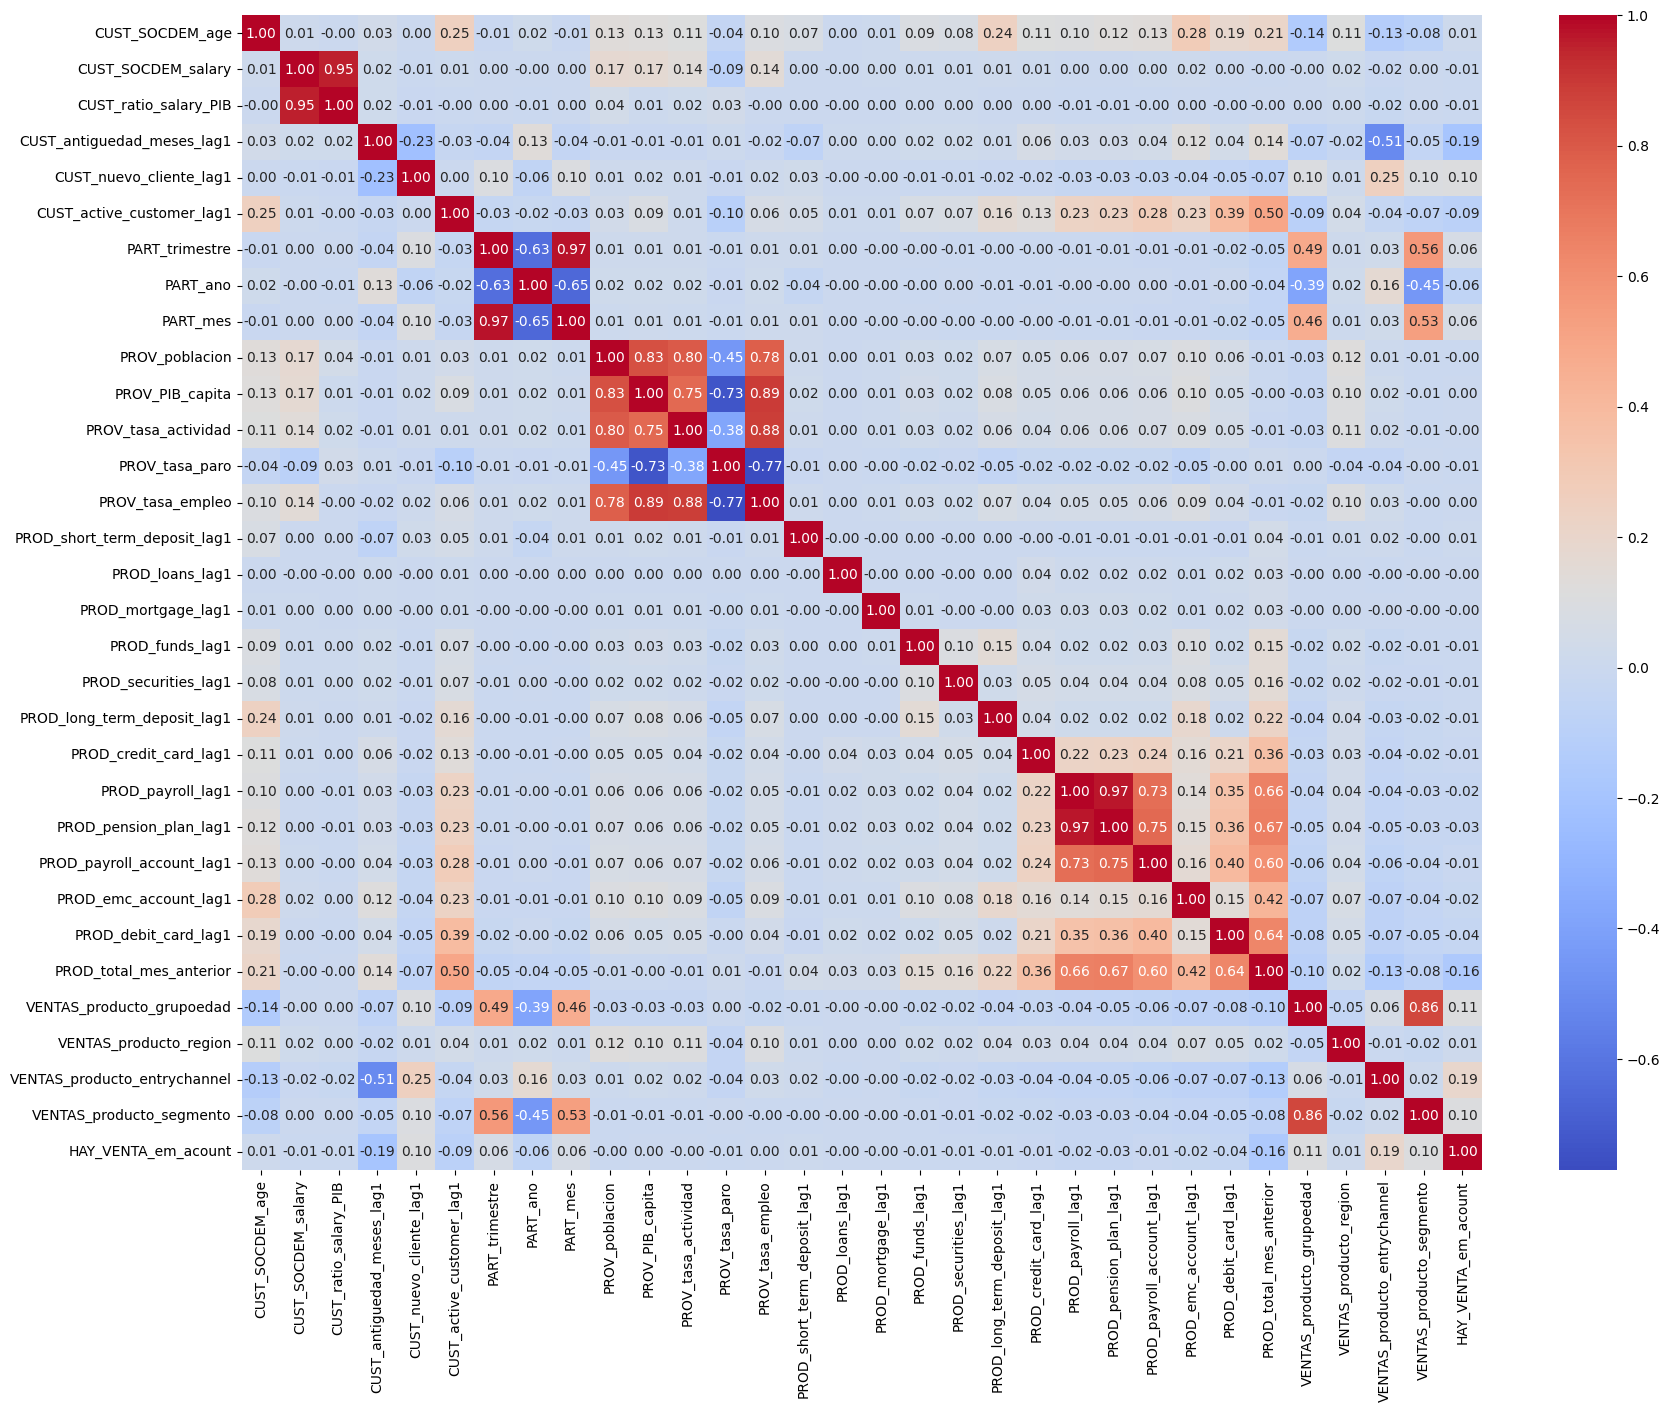

In [16]:
# Correlation Matrix: Check if any variable strongly correlates with the target. There are none.
# Select numeric columns
df_numericas = df[columnas_CUST + columnas_PART + columnas_PROV + columnas_PROD + columnas_VENTAS+ [TARGET] ].select_dtypes(include=['number'])

# Correlation matrix
corr_matriz_num = df_numericas.corr()

# Plot
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matriz_num, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

### Combination of features for the model

In [ ]:
# After testing several combinations of features, we chose this set because it performs the best.
col_final = ['PART_ano','PART_mes','CUST_entry_channel',
 'CUST_active_customer_lag1',
 'CUST_segment',
 'CUST_SOCDEM_gender',
 'CUST_SOCDEM_age',
 'CUST_SOCDEM_salary',
 'CUST_nuevo_cliente_lag1',
 'CUST_antiguedad_meses_lag1',
 'PROV_poblacion',
 'PROV_PIB_capita',
 'VENTAS_producto_grupoedad',
 'VENTAS_producto_region',
 'VENTAS_producto_entrychannel',
 'VENTAS_producto_segmento',
 'provincia',"CUST_ratio_salary_PIB"] + columnas_PROD + [TARGET]

df= df[col_final]

In [18]:
col_final

['PART_ano',
 'PART_mes',
 'CUST_entry_channel',
 'CUST_active_customer_lag1',
 'CUST_segment',
 'CUST_SOCDEM_gender',
 'CUST_SOCDEM_age',
 'CUST_SOCDEM_salary',
 'CUST_nuevo_cliente_lag1',
 'CUST_antiguedad_meses_lag1',
 'PROV_poblacion',
 'PROV_PIB_capita',
 'VENTAS_producto_grupoedad',
 'VENTAS_producto_region',
 'VENTAS_producto_entrychannel',
 'VENTAS_producto_segmento',
 'provincia',
 'CUST_ratio_salary_PIB',
 'PROD_short_term_deposit_lag1',
 'PROD_loans_lag1',
 'PROD_mortgage_lag1',
 'PROD_funds_lag1',
 'PROD_securities_lag1',
 'PROD_long_term_deposit_lag1',
 'PROD_credit_card_lag1',
 'PROD_payroll_lag1',
 'PROD_pension_plan_lag1',
 'PROD_payroll_account_lag1',
 'PROD_emc_account_lag1',
 'PROD_debit_card_lag1',
 'PROD_total_mes_anterior',
 'HAY_VENTA_em_acount']

### Check dataset size

In [19]:
df.shape

(5759288, 32)

### Verify that no null values remain

In [20]:
df.isnull().sum()

PART_ano                        0
PART_mes                        0
CUST_entry_channel              0
CUST_active_customer_lag1       0
CUST_segment                    0
CUST_SOCDEM_gender              0
CUST_SOCDEM_age                 0
CUST_SOCDEM_salary              0
CUST_nuevo_cliente_lag1         0
CUST_antiguedad_meses_lag1      0
PROV_poblacion                  0
PROV_PIB_capita                 0
VENTAS_producto_grupoedad       0
VENTAS_producto_region          0
VENTAS_producto_entrychannel    0
VENTAS_producto_segmento        0
provincia                       0
CUST_ratio_salary_PIB           0
PROD_short_term_deposit_lag1    0
PROD_loans_lag1                 0
PROD_mortgage_lag1              0
PROD_funds_lag1                 0
PROD_securities_lag1            0
PROD_long_term_deposit_lag1     0
PROD_credit_card_lag1           0
PROD_payroll_lag1               0
PROD_pension_plan_lag1          0
PROD_payroll_account_lag1       0
PROD_emc_account_lag1           0
PROD_debit_car

In [21]:
target_col = df[TARGET]
target_col

239394     0
239395     0
239396     0
239397     1
239398     0
          ..
5998677    0
5998678    0
5998679    0
5998680    0
5998681    1
Name: HAY_VENTA_em_acount, Length: 5759288, dtype: int64

### Function to create lists of numeric, boolean, and categorical variables

In [22]:
def obtener_lista_variables(dataset):
  lista_numericas = []
  lista_boolean = []
  lista_categoricas = []

  for i in dataset:
    if (dataset[i].dtype.kind == "i" or dataset[i].dtype.kind == "f") and dataset[i].nunique() > 2 and i not in target_col:
      lista_numericas.append(i)
    elif (dataset[i].dtype.kind == "i" or dataset[i].dtype.kind == "f") and  dataset[i].nunique() <= 2 and  i not in target_col:
      lista_boolean.append(i)
    elif dataset[i].dtype.kind == "O" and i not in target_col:
      lista_categoricas.append(i)

  return lista_numericas, lista_boolean, lista_categoricas

In [23]:
num, bol, cat = obtener_lista_variables(df)

In [24]:
num

['PART_mes',
 'CUST_SOCDEM_age',
 'CUST_SOCDEM_salary',
 'CUST_antiguedad_meses_lag1',
 'PROV_poblacion',
 'PROV_PIB_capita',
 'VENTAS_producto_grupoedad',
 'VENTAS_producto_region',
 'VENTAS_producto_entrychannel',
 'VENTAS_producto_segmento',
 'CUST_ratio_salary_PIB',
 'PROD_total_mes_anterior']

In [25]:
bol

['PART_ano',
 'CUST_active_customer_lag1',
 'CUST_nuevo_cliente_lag1',
 'PROD_short_term_deposit_lag1',
 'PROD_loans_lag1',
 'PROD_mortgage_lag1',
 'PROD_funds_lag1',
 'PROD_securities_lag1',
 'PROD_long_term_deposit_lag1',
 'PROD_credit_card_lag1',
 'PROD_payroll_lag1',
 'PROD_pension_plan_lag1',
 'PROD_payroll_account_lag1',
 'PROD_emc_account_lag1',
 'PROD_debit_card_lag1',
 'HAY_VENTA_em_acount']

In [26]:
cat

['CUST_entry_channel', 'CUST_segment', 'CUST_SOCDEM_gender', 'provincia']

### Analysis of unique values for categorical variables, before OHE

In [27]:
# Count the number of unique values for each column
conteo_unique = {col: df[col].nunique() for col in cat}
conteo_unique


{'CUST_entry_channel': 68,
 'CUST_segment': 4,
 'CUST_SOCDEM_gender': 2,
 'provincia': 52}

In [28]:
# Function to count values under each column and calculate their percentage (to determine if some can be grouped under "others")
def unique_conteo_y_porcentaje(df, columnas):
    resultados = {}
    for col in columnas:
        conteo = df[col].value_counts()
        porcentaje = df[col].value_counts(normalize=True) * 100

        # Create a DataFrame with the results
        df_resultado = pd.DataFrame({'Conteo': conteo, 'Porcentaje (%)': porcentaje})

        # Add to the results dictionary
        resultados[col] = df_resultado

        # Print visualization for each column
        print(f"Tabla de resumen para '{col}':")
        print(df_resultado.to_string())
        print("\n" + "-"*50 + "\n")  # Separador visual

    return resultados

In [29]:
resultados = unique_conteo_y_porcentaje(df,cat)

Tabla de resumen para 'CUST_entry_channel':
                     Conteo  Porcentaje (%)
CUST_entry_channel                         
KHE                 2959520           51.39
KFC                  857763           14.89
KHQ                  666923           11.58
KAT                  397889            6.91
KHK                  230651            4.00
KHM                  211992            3.68
KHN                  126499            2.20
KFA                   76131            1.32
KHD                   72146            1.25
RED                   61334            1.06
KHL                   42198            0.73
KHF                   20013            0.35
KHO                    9772            0.17
desconocido            9448            0.16
KAZ                    5408            0.09
KHC                    5003            0.09
KBG                    1594            0.03
KHP                     778            0.01
KEH                     691            0.01
007                     588     

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5759288 entries, 239394 to 5998681
Data columns (total 32 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   PART_ano                      int64  
 1   PART_mes                      int64  
 2   CUST_entry_channel            object 
 3   CUST_active_customer_lag1     float64
 4   CUST_segment                  object 
 5   CUST_SOCDEM_gender            object 
 6   CUST_SOCDEM_age               int64  
 7   CUST_SOCDEM_salary            int64  
 8   CUST_nuevo_cliente_lag1       float64
 9   CUST_antiguedad_meses_lag1    float64
 10  PROV_poblacion                int64  
 11  PROV_PIB_capita               int64  
 12  VENTAS_producto_grupoedad     float64
 13  VENTAS_producto_region        float64
 14  VENTAS_producto_entrychannel  float64
 15  VENTAS_producto_segmento      float64
 16  provincia                     object 
 17  CUST_ratio_salary_PIB         float64
 18  PROD_short_term_d

### One Hot Encoding (OHE) for categorical variables

In [31]:
df1 = df.copy()

In [32]:
def OHE(dataframe, column_name):
    _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix=column_name)
    dataframe = pd.concat([dataframe, _dummy_dataset], axis=1)
    return dataframe.drop(column_name, axis=1)

In [33]:
df1 = OHE(df1,cat)

### Transform boolean variables (to uint8)


In [34]:
def transformar_bool (df):
  bool_col=df1.select_dtypes(include=["bool"]).columns
  df1[bool_col]=df1[bool_col].astype("uint8")
  return df

In [35]:
df1 = transformar_bool(df1)

In [36]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5759288 entries, 239394 to 5998681
Columns: 154 entries, PART_ano to provincia_Ávila
dtypes: float64(18), int64(10), uint8(126)
memory usage: 1.9 GB


In [37]:
df1.head().T

,239394,239395,239396,239397,239398
PART_ano,2018.00,2018.00,2018.00,2018.00,2018.00
PART_mes,2.00,2.00,2.00,2.00,2.00
CUST_active_customer_lag1,1.00,1.00,1.00,0.00,0.00
CUST_SOCDEM_age,41.00,65.00,47.00,39.00,68.00
CUST_SOCDEM_salary,133948.00,84237.00,110358.00,164911.00,122359.00
...,...,...,...,...,...
provincia_Valencia/València,0.00,0.00,0.00,0.00,0.00
provincia_Valladolid,0.00,0.00,0.00,0.00,0.00
provincia_Zamora,0.00,0.00,0.00,0.00,0.00
provincia_Zaragoza,0.00,0.00,0.00,0.00,0.00


### Data Modeling and Evaluation

In [38]:
df2 = df1.copy()

In [39]:
df2.shape

(5759288, 154)

In [40]:
df2.pivot_table(index = ['PART_ano','PART_mes'], values = TARGET, aggfunc = [len, sum, np.mean])

C:\Users\mirei\AppData\Local\Temp\ipykernel_16792\4012723101.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df2.pivot_table(index = ['PART_ano','PART_mes'], values = TARGET, aggfunc = [len, sum, np.mean])
C:\Users\mirei\AppData\Local\Temp\ipykernel_16792\4012723101.py:1: FutureWarning: The provided callable <function mean at 0x0000028DA5C6AC00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df2.pivot_table(index = ['PART_ano','PART_mes'], values = TARGET, aggfunc = [len, sum, np.mean])


len                 sum                mean
                  HAY_VENTA_em_acount HAY_VENTA_em_acount HAY_VENTA_em_acount
PART_ano PART_mes                                                            
2018     2                     245610                4153                0.02
         3                     247417                3516                0.01
         4                     249346                3003                0.01
         5                     251693                3064                0.01
         6                     254236                4710                0.02
         7                     342151               12437                0.04
         8                     355091               14125                0.04
         9                     377211               17512                0.05
         10                    404676               18988                0.05
         11                    418950               10517                0.03
         12                    425326                6221                0.01
2019     1                     428604                5137                0.01
         2                     433845                3951                0.01
         3                     438365                4209                0.01
         4                     441626                3011                0.01
         5                     445141                2858                0.01

In [41]:
# Create validation dataset with the last three partitions
df_val = df2[df2['PART_ano'] * 100 + df2['PART_mes'] >= 201903]


In [42]:
df_agrupado = df_val.groupby(['PART_ano', 'PART_mes'])[TARGET].sum().reset_index()
df_agrupado

,PART_ano,PART_mes,HAY_VENTA_em_acount
0,2019,3,4209
1,2019,4,3011
2,2019,5,2858


In [43]:
# Remove PART_ano and PART_mes from df
df.drop(['PART_ano','PART_mes'], axis = 1, inplace = True)

In [44]:

df_dev = df2.drop(df_val.index)

In [45]:
# Remove PART_ANO and PART_MES from df_dev
df_dev.drop(['PART_ano','PART_mes'], axis = 1, inplace = True)

In [46]:
# Remove PART_ANO and PART_MES from df_val
df_val.drop(['PART_ano','PART_mes'], axis = 1, inplace = True)

C:\Users\mirei\AppData\Local\Temp\ipykernel_16792\129409617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.drop(['PART_ano','PART_mes'], axis = 1, inplace = True)


In [47]:
df.shape

(5759288, 30)

In [48]:
df_val.shape

(1325132, 152)

In [49]:
df_dev.shape

(4434156, 152)

In [50]:
# We use 23% of our dataset as validation dataset. 
df_val.shape[0]/df2.shape[0]*100

23.00860800848994

### Train-test split function, model training, and evaluation metrics.


In [51]:
def lanzar_modelo(dataframe_dev,dataframe_val,col_target,test_proporcion,model):

#dividir dataset developement y validation
  dataframe_dev_y = df_dev[[TARGET]]
  dataframe_dev_X = df_dev.drop(TARGET, axis = 1)
  dataframe_val_y = df_val[[TARGET]]
  dataframe_val_X = df_val.drop(TARGET, axis = 1)

#partición train-test del dataset developement
  X_train, X_test, y_train, y_test = model_selection.train_test_split(dataframe_dev_X, dataframe_dev_y, test_size=test_proporcion, random_state=42)

#entrenar el modelo
  model.fit(X_train, y_train)


#predicciones sobre train, test y validation
  y_train_predict = model.predict(X_train)
  y_test_predict = model.predict(X_test)
  y_val_predict = model.predict(dataframe_val_X)

#ROC_curve_train
  predictions = model.predict_proba(X_train)[:,1]
  auc_score_train = metrics.roc_auc_score(y_train, predictions)
  fpr, tpr, _ = metrics.roc_curve(y_train, predictions)

#ROC_curve_test
  predictions = model.predict_proba(X_test)[:,1]
  auc_score_test = metrics.roc_auc_score(y_test, predictions)
  fpr, tpr, _ = metrics.roc_curve(y_test, predictions)

  print(f"modelo = {model}")
#Accuracy
  print(f"accuracy train = {accuracy_score(y_train, y_train_predict)}")
  print(f"accuracy test = {accuracy_score(y_test, y_test_predict)}")
  print(f"accuracy validation = {accuracy_score(dataframe_val_y, y_val_predict)}")
  print("\n")

#Confusion Matrix
  print(f"confusion_matrix_train =\n {confusion_matrix(y_train, y_train_predict)}")
  print("\n")

#Precision
  print(f"precision train = {precision_score(y_train, y_train_predict)}")
  print(f"precision test = {precision_score(y_test, y_test_predict)}")
  print(f"precision validation = {precision_score(dataframe_val_y, y_val_predict)}")
  print("\n")

#Recall
  print(f"recall train = {recall_score(y_train, y_train_predict)}")
  print(f"recall test = {recall_score(y_test, y_test_predict)}")
  print(f"recall validation = {recall_score(dataframe_val_y, y_val_predict)}")
  print("\n")

#F1-score
  print(f"F1-score train = {f1_score(y_train, y_train_predict)}")
  print(f"F1-score test = {f1_score(y_test, y_test_predict)}")
  print(f"F1-score validation = {f1_score(dataframe_val_y, y_val_predict)}")
  print("\n")

#precision balanceada
  print(f"balanced_accuracy train = {balanced_accuracy_score(y_train, y_train_predict)}")
  print(f"balanced_accuracy test = {balanced_accuracy_score(y_test, y_test_predict)}")
  print(f"balanced_accuracy validation = {balanced_accuracy_score(dataframe_val_y, y_val_predict)}")
  print("\n")


#plotear ROC curve
  print('ROC AUC Score (train) for {}: {}'.format(model, auc_score_train))
  print('ROC AUC Score (test) for {}: {}'.format(model, auc_score_test))
  plt.plot(fpr, tpr, label='ROC Curve (test) for {} - Area: {:2f}'.format(model, auc_score_test))
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  #plt.legend(loc="lower right")
  plt.title('ROC curve (test)')
  plt.show()

### XGBOOST


In [53]:
xg_boost = xgb.XGBClassifier(
    n_estimators=200,  #Aumentamos el número de árboles para permitir que el modelo tenga más tiempo de aprendizaje con un learning_rate más bajo.
    learning_rate=0.05, #Un learning_rate más bajo ayuda a que el modelo aprenda más lentamente, evitando sobreajuste y mejorando la generalización.
    max_depth=8,     # Aumentado para capturar relaciones más complejas. Aumentamos la profundidad máxima de los árboles para capturar interacciones más complejas entre las características, lo que puede mejorar el recall.
    subsample=0.8,   # Mantiene un nivel de aleatoriedad para reducir sobreajuste
    colsample_bytree=0.8, # Igual, seleccionando subconjuntos de características
    objective='binary:logistic',
    gamma=0.3, # Aumentamos el parámetro gamma para que el modelo sea más conservador al crear nodos adicionales en los árboles, reduciendo el riesgo de sobreajuste.
    min_child_weight=5, # .Incrementamos este parámetro para exigir un mínimo mayor de observaciones en las hojas de los árboles, lo que reduce la probabilidad de ajustes a ruido.
    scale_pos_weight=10,  # Ajustado para manejar el desequilibrio de clases (ajusta según la proporción real de tus datos)
    random_state=42   #Mantener para reproducibilidad


)



modelo = XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
accuracy train = 0.9787352381682644
accuracy test = 0.978602486152958
accuracy validation = 0.9856844450213261


confusion_matrix_train =
 [[3390928   70654]
 [   4779   80963]]


precision train = 0.533996847319232
precision test = 0.534453692

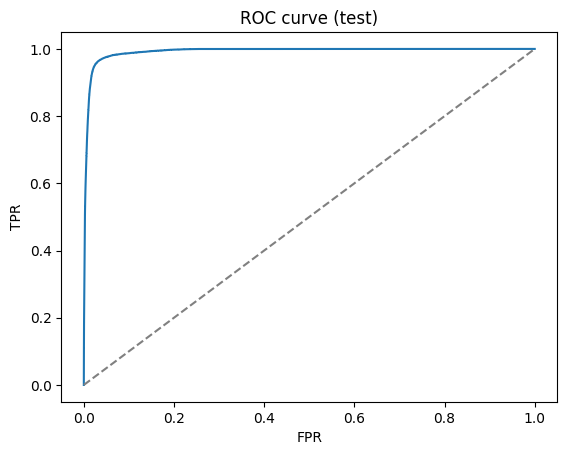

In [54]:
lanzar_modelo(df_dev,df_val,"HAY_VENTA_em_acount",0.2, xg_boost)

### Top Features

In [55]:
top_features_XGB = pd.Series(xg_boost.feature_importances_,
                         index=df_dev.drop(TARGET, axis=1).columns).sort_values(ascending=False).head(20)

In [56]:
top_features_XGB

CUST_antiguedad_meses_lag1        0.30
PROD_total_mes_anterior           0.09
CUST_entry_channel_KHE            0.09
PROD_pension_plan_lag1            0.07
PROD_payroll_account_lag1         0.06
PROD_short_term_deposit_lag1      0.03
CUST_entry_channel_KFC            0.03
CUST_nuevo_cliente_lag1           0.02
PROD_long_term_deposit_lag1       0.02
CUST_segment_desconocido          0.02
CUST_active_customer_lag1         0.02
CUST_entry_channel_KHQ            0.02
PROD_emc_account_lag1             0.01
CUST_segment_03 - UNIVERSITARIO   0.01
VENTAS_producto_entrychannel      0.01
PROD_debit_card_lag1              0.01
VENTAS_producto_segmento          0.01
provincia_Madrid                  0.01
CUST_entry_channel_desconocido    0.01
CUST_entry_channel_KHD            0.01
dtype: float32

<Axes: >

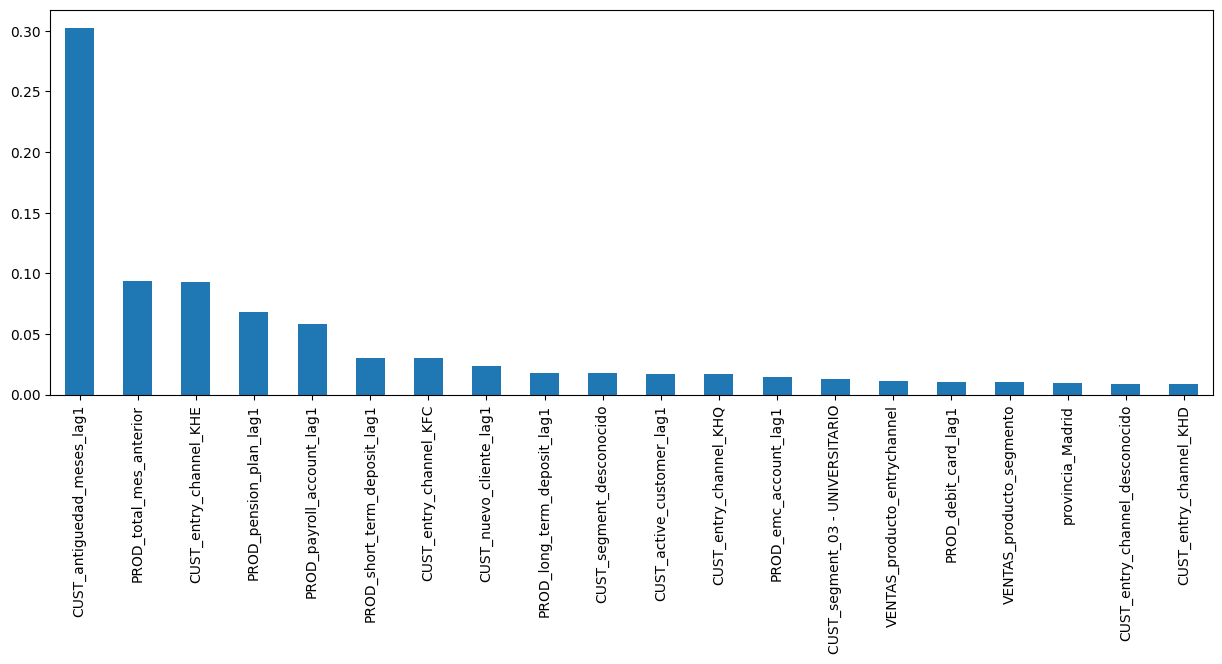

In [57]:
plt.figure(figsize=(15,5))
top_features_XGB.plot(kind='bar')